In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [49]:
from IPython.core.interactiveshell import InteractiveShell

# Set to display all output in one go without needing to scroll
InteractiveShell.ast_node_interactivity = "all"


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hijest/genre-classification-dataset-imdb")

print("Path to dataset files:", path)

100%|██████████| 41.7M/41.7M [00:00<00:00, 45.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hijest/genre-classification-dataset-imdb/versions/1


In [3]:
import os

# Path to the dataset files
dataset_path = "/root/.cache/kagglehub/datasets/hijest/genre-classification-dataset-imdb/versions/1"

# List files in the directory
files = os.listdir(dataset_path)
print(files)


['Genre Classification Dataset']


In [4]:
# Path to the subdirectory
subdirectory_path = os.path.join(dataset_path, "Genre Classification Dataset")

# List files in the subdirectory
files = os.listdir(subdirectory_path)
print(files)


['train_data.txt', 'description.txt', 'test_data_solution.txt', 'test_data.txt']


# Text Cleaning

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
nltk.download('stopwords')
nltk.download('wordnet')
file_path = os.path.join(subdirectory_path, "train_data.txt")
data = pd.read_csv(file_path, sep=r'\s*:::\s*', engine='python', header=None, names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])
print(data.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


   ID                             TITLE     GENRE  \
0   1      Oscar et la dame rose (2009)     drama   
1   2                      Cupid (1997)  thriller   
2   3  Young, Wild and Wonderful (1980)     adult   
3   4             The Secret Sin (1915)     drama   
4   5            The Unrecovered (2007)     drama   

                                         DESCRIPTION  
0  Listening in to a conversation between his doc...  
1  A brother and sister with a past incestuous re...  
2  As the bus empties the students for their fiel...  
3  To help their unemployed father make ends meet...  
4  The film's title refers not only to the un-rec...  


Number of movies in each genre:
GENRE
drama          13613
documentary    13096
comedy          7447
short           5073
horror          2204
thriller        1591
action          1315
western         1032
reality-tv       884
family           784
adventure        775
music            731
romance          672
sci-fi           647
adult            590
crime            505
animation        498
sport            432
talk-show        391
fantasy          323
mystery          319
musical          277
biography        265
history          243
game-show        194
news             181
war              132
Name: count, dtype: int64


<ipython-input-7-9120cb486008>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Genre', y='Number of Movies', data=genre_counts, palette='viridis')


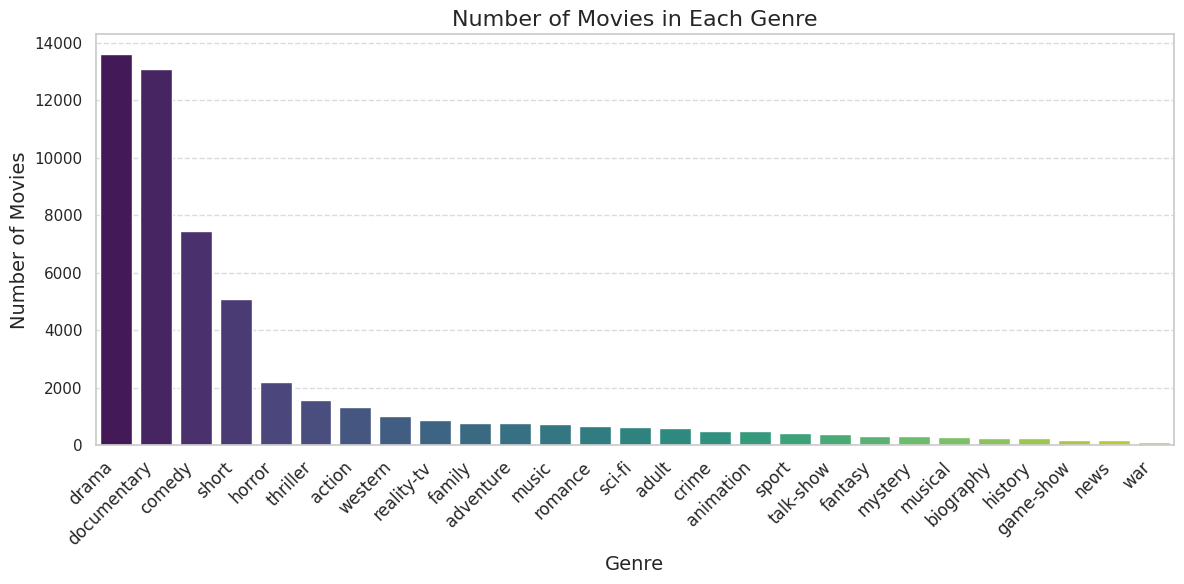

In [7]:

genre_counts = data['GENRE'].value_counts()

# Display the counts
print("Number of movies in each genre:")
print(genre_counts)
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Assuming 'data' is your DataFrame containing the movie data
# Grouping by 'GENRE' and counting the number of movies in each genre
genre_counts = data['GENRE'].value_counts().reset_index()
genre_counts.columns = ['Genre', 'Number of Movies']

# Plotting the genre counts with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Genre', y='Number of Movies', data=genre_counts, palette='viridis')

# Adding title and labels
plt.title('Number of Movies in Each Genre', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()



Data Augmentation

In [8]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [11]:
import random
import nltk
from nltk.corpus import wordnet

# Set the threshold to define minority genres
threshold = 4000
minority_genres = data['GENRE'].value_counts()[data['GENRE'].value_counts() < threshold].index

# Function to replace a word with its synonym
def synonym_replacement(text, n=1):
    words = nltk.word_tokenize(text)
    new_words = words.copy()

    # Choose 'n' random words to replace with synonyms
    for _ in range(n):
        random_word = random.choice(words)

        # Get synonyms from WordNet
        synonyms = wordnet.synsets(random_word)
        if synonyms:  # Check if synonyms exist
            # Choose a random synonym from the first synonym set
            synonym = random.choice(synonyms[0].lemmas()).name()  # Get the name of the lemma
            new_words = [synonym if word == random_word else word for word in new_words]

    # Join the words back into a single string
    return ' '.join(new_words)

# Augment minority genres
augmented_data = data.copy()

for genre in minority_genres:
    # Get the rows for the minority genre
    genre_rows = data[data['GENRE'] == genre]

    # Calculate how many new rows you need to match the threshold
    num_rows_to_add = threshold - len(genre_rows)

    # Sample rows randomly to duplicate
    sampled_rows = genre_rows.sample(n=num_rows_to_add, replace=True)

    # Apply synonym replacement to the DESCRIPTION column of the sampled rows
    sampled_rows['DESCRIPTION'] = sampled_rows['DESCRIPTION'].apply(lambda desc: synonym_replacement(desc, n=1))

    # Append the augmented rows to the original dataset
    augmented_data = pd.concat([augmented_data, sampled_rows], ignore_index=True)

# Check the new data distribution
print("Data Distribution After Augmentation:")
print(augmented_data['GENRE'].value_counts())



Data Distribution After Augmentation:
GENRE
drama          13613
documentary    13096
comedy          7447
short           5073
adventure       4000
musical         4000
game-show       4000
romance         4000
biography       4000
news            4000
history         4000
mystery         4000
family          4000
western         4000
talk-show       4000
sci-fi          4000
music           4000
thriller        4000
fantasy         4000
action          4000
animation       4000
sport           4000
horror          4000
reality-tv      4000
crime           4000
adult           4000
war             4000
Name: count, dtype: int64


Preprocessing data

In [24]:
import string
import nltk
import re

from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Get the English stopwords
stop_words = set(stopwords.words('english'))

# Function to preprocess text (lowercasing, removing punctuation, removing stopwords)
def preprocess_text(text):
    # Add spaces between numbers and letters first
    text = re.sub(r'(\d+)([a-zA-Z]+)', r'\1 \2', text)  # e.g., "10yearold" -> "10 yearold"
    text = re.sub(r'([a-zA-Z]+)(\d+)', r'\1 \2', text)  # e.g., "year2024" -> "year 2024"

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text (split into words)
    words = nltk.word_tokenize(text)

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Join the words back into a string
    return ' '.join(words)

# Apply preprocessing to the 'DESCRIPTION' column of the dataset
augmented_data['DESCRIPTION'] = augmented_data['DESCRIPTION'].apply(preprocess_text)

# Check the processed dataset
print(augmented_data['DESCRIPTION'].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    listening conversation doctor parents 10yearol...
1    brother sister past incestuous relationship cu...
2    bus empties students field trip museum natural...
3    help unemployed father make ends meet edith tw...
4    films title refers unrecovered bodies ground z...
Name: DESCRIPTION, dtype: object


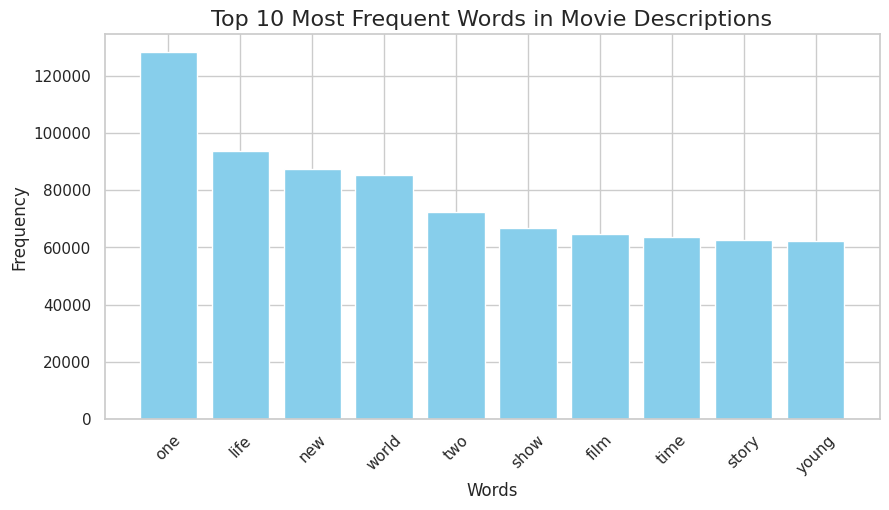

In [26]:
from collections import Counter

# Tokenize all descriptions into words
all_words = ' '.join(augmented_data['DESCRIPTION']).split()

# Count the frequency of each word
word_counts = Counter(all_words)

# Get the most common words
most_common_words = word_counts.most_common(10)  # Adjust the number to visualize more or fewer words
words, counts = zip(*most_common_words)

# Create a bar chart
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='skyblue')
plt.title('Top 10 Most Frequent Words in Movie Descriptions', fontsize=16)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.show()


In [33]:
# Print the number of data points (rows) in the dataset
num_data_points = augmented_data.shape[0]
print(f'The dataset contains {num_data_points} data points.')
print(augmented_data.shape)
print(data.shape)

The dataset contains 131229 data points.
(131229, 5)
(54214, 4)


Number of movies in each genre:
GENRE
drama          13613
documentary    13096
comedy          7447
short           5073
adventure       4000
musical         4000
game-show       4000
romance         4000
biography       4000
news            4000
history         4000
mystery         4000
family          4000
western         4000
talk-show       4000
sci-fi          4000
music           4000
thriller        4000
fantasy         4000
action          4000
animation       4000
sport           4000
horror          4000
reality-tv      4000
crime           4000
adult           4000
war             4000
Name: count, dtype: int64


<ipython-input-34-9bd385fe18f5>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Genre', y='Number of Movies', data=genre_counts, palette='viridis')


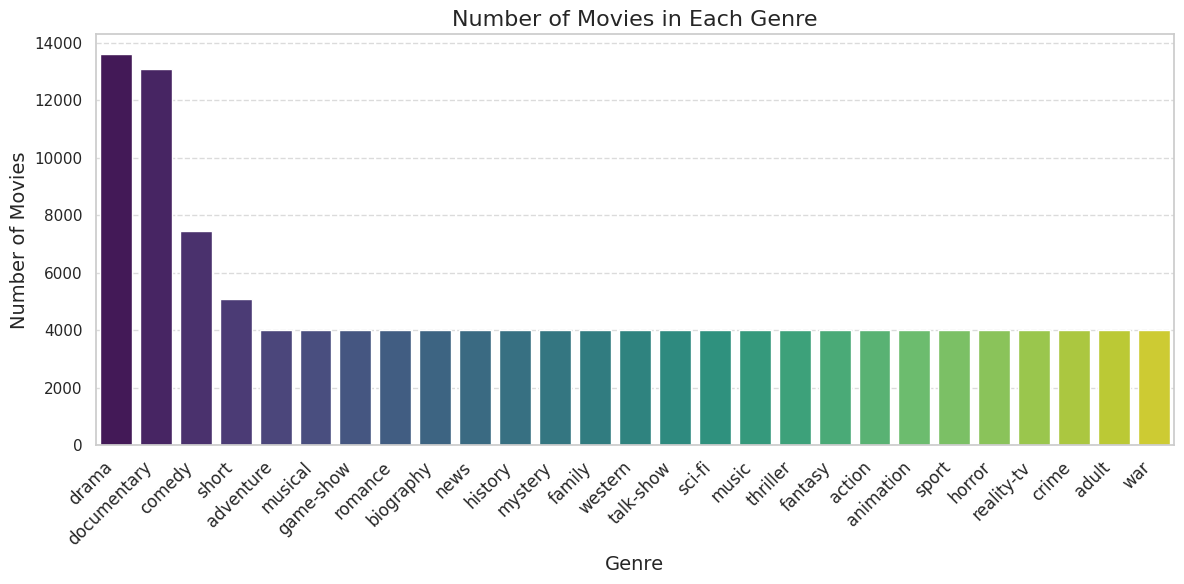

In [34]:
genre_counts = augmented_data['GENRE'].value_counts()

# Display the counts
print("Number of movies in each genre:")
print(genre_counts)
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Assuming 'data' is your DataFrame containing the movie data
# Grouping by 'GENRE' and counting the number of movies in each genre
genre_counts = augmented_data['GENRE'].value_counts().reset_index()
genre_counts.columns = ['Genre', 'Number of Movies']

# Plotting the genre counts with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Genre', y='Number of Movies', data=genre_counts, palette='viridis')

# Adding title and labels
plt.title('Number of Movies in Each Genre', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


**Train Model: GloVe embeddings**

In [19]:
# Download GloVe 100d embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2024-10-22 03:56:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-10-22 03:56:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-10-22 03:56:39--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [20]:
# Unzip the downloaded file
!unzip glove.6B.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       

In [28]:
import numpy as np

# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')


In [29]:
def vectorize_text(text, embeddings):
    words = text.split()
    valid_vectors = [embeddings[word] for word in words if word in embeddings]
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    else:
        return np.zeros(100)  # Adjust the dimension based on the GloVe vectors you are using

# Apply vectorization to the DESCRIPTION column of the augmented dataset
augmented_data['VECTOR'] = augmented_data['DESCRIPTION'].apply(lambda x: vectorize_text(x, glove_embeddings))


In [30]:
print(augmented_data[['DESCRIPTION', 'VECTOR']].head())


                                         DESCRIPTION  \
0  listening conversation doctor parents 10yearol...   
1  brother sister past incestuous relationship cu...   
2  bus empties students field trip museum natural...   
3  help unemployed father make ends meet edith tw...   
4  films title refers unrecovered bodies ground z...   

                                              VECTOR  
0  [0.12818898, 0.22687887, 0.21363391, -0.028038...  
1  [0.39997143, 0.16687742, 0.09574237, 0.0028513...  
2  [0.045733564, 0.23052654, 0.26308125, -0.02856...  
3  [0.12966399, 0.12653482, 0.15932523, -0.169316...  
4  [0.011652206, 0.1742737, 0.29259452, -0.005513...  


In [35]:
# Prepare input features and labels
X = np.array(augmented_data['VECTOR'].tolist())  # Features: The vector representations
y = augmented_data['GENRE'].values  # Labels: The genres

# Check the shape of the features and labels
print("Input features shape:", X.shape)
print("Labels shape:", y.shape)

Input features shape: (131229, 100)
Labels shape: (131229,)


Logistic Regression

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [37]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [38]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      action       0.43      0.33      0.37       800
       adult       0.56      0.64      0.60       800
   adventure       0.32      0.19      0.24       800
   animation       0.42      0.40      0.41       800
   biography       0.37      0.22      0.27       800
      comedy       0.36      0.36      0.36      1489
       crime       0.41      0.34      0.37       800
 documentary       0.43      0.57      0.49      2619
       drama       0.38      0.58      0.46      2723
      family       0.34      0.23      0.28       800
     fantasy       0.41      0.39      0.40       800
   game-show       0.82      0.85      0.83       800
     history       0.41      0.34      0.37       800
      horror       0.46      0.46      0.46       800
       music       0.60      0.67      0.63       800
     musical       0.47      0.38      0.42       800
     mystery       0.35      0.33      0.34       800
        news       0.54    

In [41]:
# Create SVM model
svm_model = svm.SVC(kernel='linear', C=1, random_state=42)

# Train the model
svm_model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = svm_model.predict(X_test)
# Print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      action       0.43      0.40      0.41       800
       adult       0.59      0.69      0.64       800
   adventure       0.36      0.27      0.31       800
   animation       0.47      0.46      0.46       800
   biography       0.48      0.33      0.39       800
      comedy       0.37      0.38      0.37      1489
       crime       0.42      0.43      0.42       800
 documentary       0.44      0.61      0.51      2619
       drama       0.39      0.59      0.47      2723
      family       0.40      0.22      0.29       800
     fantasy       0.48      0.44      0.46       800
   game-show       0.88      0.92      0.90       800
     history       0.54      0.46      0.50       800
      horror       0.50      0.46      0.48       800
       music       0.66      0.71      0.68       800
     musical       0.55      0.47      0.51       800
     mystery       0.46      0.37      0.41       800
        news       0.65    

In [63]:
import joblib
from google.colab import files
# Save the logistic regression model
joblib.dump(model, 'logistic_model.pkl')

# Save the SVM model
joblib.dump(svm_model, 'svm_model.pkl')
files.download('logistic_model.pkl')
files.download('svm_model.pkl')

['logistic_model.pkl']

['svm_model.pkl']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Prediction

In [45]:

def predict_genre(description, model, embeddings):
    # Step 1: Preprocess the input description
    processed_description = preprocess_text(description)

    # Step 2: Vectorize the preprocessed text using your vectorize_text function
    vectorized_description = vectorize_text(processed_description, embeddings)

    # Reshape the vector for the model input
    vectorized_description = vectorized_description.reshape(1, -1)  # Reshape to 2D array for the model

    # Step 3: Make the prediction
    predicted_genre = model.predict(vectorized_description)

    return predicted_genre[0]  # Return the predicted genre

Logistic Regression

In [55]:

description=input("Enter Movie Description: ")
predicted_genre = predict_genre(description, model, glove_embeddings)
from IPython.core.display import display, HTML

# Enable text wrapping in output
display(HTML('''
<style>
.output {
    flex-direction: column;
    white-space: normal;
}
</style>
'''))

# Example of long output


print(f"Predicted Genre: {predicted_genre}")

Enter Movie Description: One year in the life of Albin and his family of shepherds in the North of Transylvania. In direct cinema style, this documentary follows their day to day routines, and their struggle to adapt to a new world where traditions are gradually replaced by modern values. Since joining the EU, Romania has been facing, like several other Eastern European countries, the pressure of modern values, introducing in farmer's lives the cruel notion of competition, the temptation of migrating to the higher salaries abroad, and the marginalization of locally produced food against industrial products.


Predicted Genre: documentary


In [57]:

description=input("Enter Movie Description: ")
predicted_genre = predict_genre(description, model, glove_embeddings)
from IPython.core.display import display, HTML

# Enable text wrapping in output
display(HTML('''
<style>
.output {
    flex-direction: column;
    white-space: normal;
}
</style>
'''))

# Example of long output


print(f"Predicted Genre: {predicted_genre}")

Enter Movie Description: His father has died, he hasn't spoken with his brother for about 10 years and has a serious cancer. Diego is a talented film director with difficulty to deal with his sickness, which is making him lose his friends and family. His best friend and doctor Ricardo gives him the news that he needs a bone marrow transplantation, otherwise he'll die. He gets married to a beautiful woman, Livia, just before going to Seattle to get treatment. There, he undergoes numerous medical procedures. During treatment, he meets an Hindu boy, with whom he plays and whom he tells amazing stories. Odds are against him and when stakes are the highest, Diego gets a visit from a very uncommon man.


Predicted Genre: drama
